# Stock Trading Example

Environment representation:

- Balance
- Close prices
- Technical indicators

Action space: For each stock, we can buy, sell or hold, represented by a number between (-max_holding, +max_holding). If the action is negative, then sell; if the action is positive, buy; if the action is 0, hold.

Reward function: Change in porfolio value.


In [ ]:
import sys

sys.path.append("..")

In [ ]:
from agents.drl_agent import DRLAgent
from config import config, config_indicators, config_models
from environments.env_stock_trading import StockTradingEnvWrapper
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.findata_visualiser import FinancialDataVisualiser
from visualiser.model_visualiser import ModelVisualiser

In [ ]:
import os

if not os.path.exists("../" + config.MODELS_DIR):
    os.makedirs("../" + config.MODELS_DIR)

if not os.path.exists("../" + config.RESULTS_DIR):
    os.makedirs("../" + config.RESULTS_DIR)

if not os.path.exists("../" + config.LOGS_DIR):
    os.makedirs("../" + config.LOGS_DIR)

In [ ]:
# If train is False, load the model from the models directory
TRAIN = False

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    f"../{config.DATA_DIR}", config.TEST_NAME
)

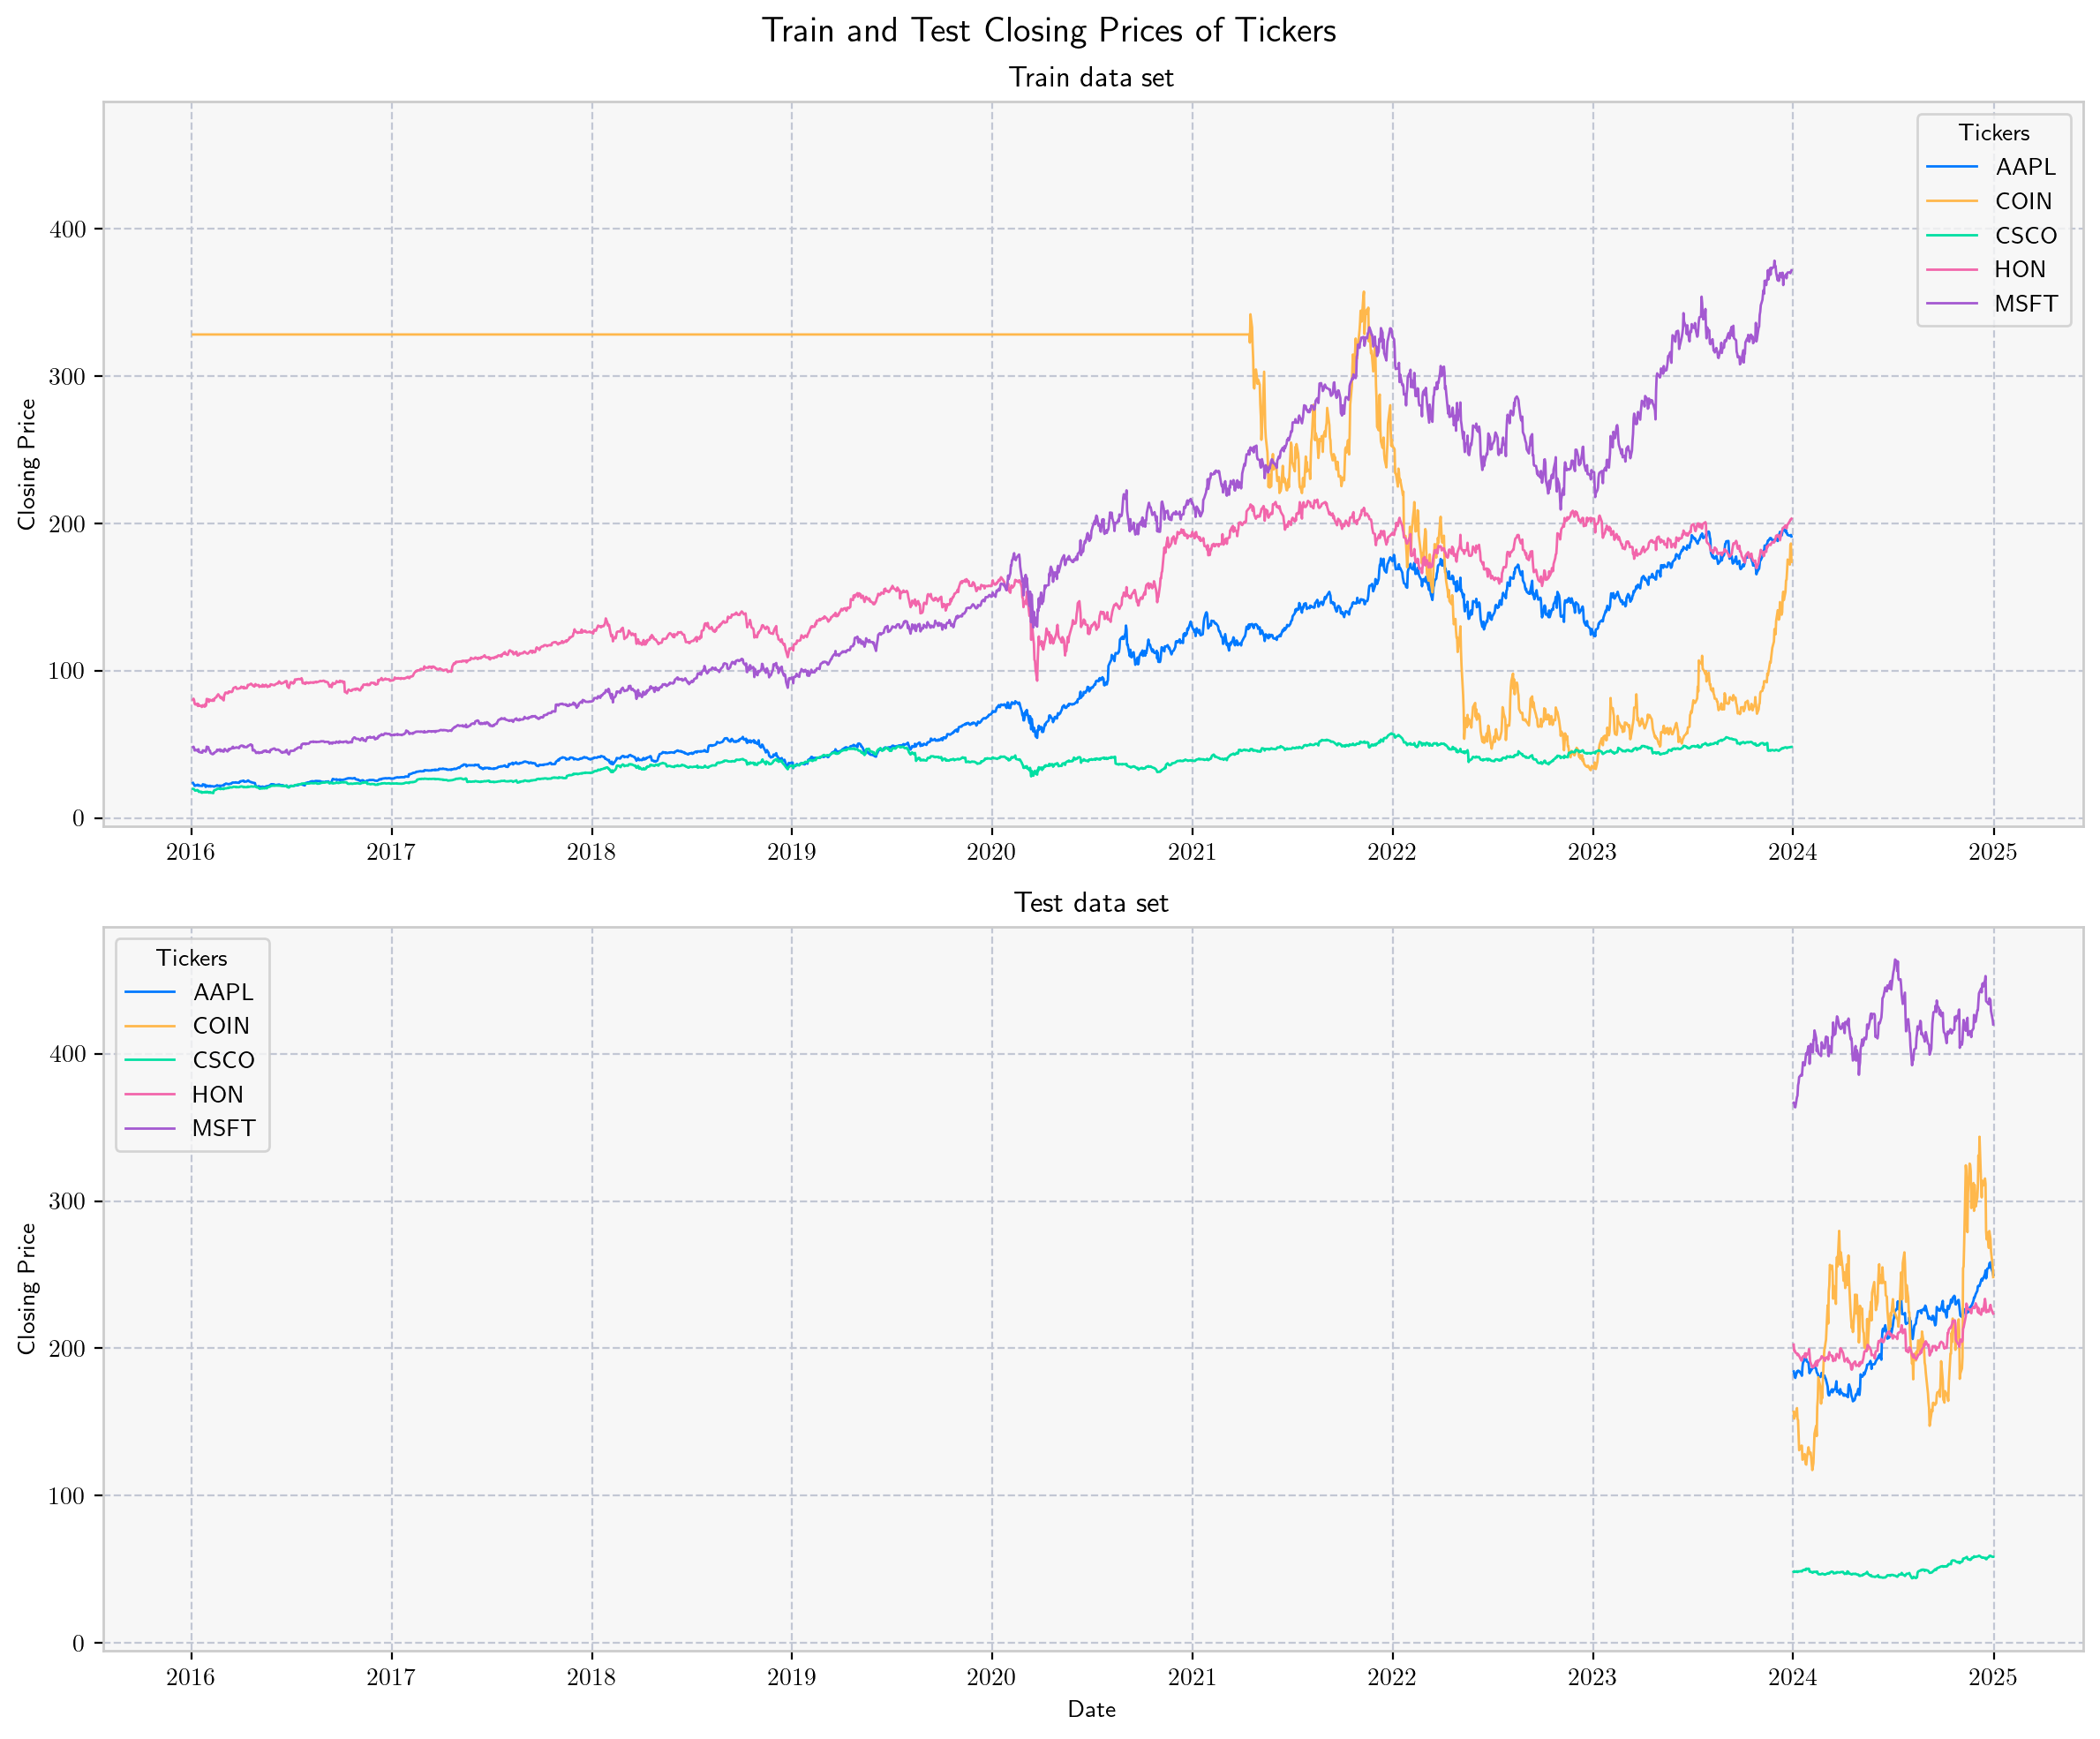

In [ ]:
finvisualiser = FinancialDataVisualiser()
finvisualiser.plot_train_test_close_prices(
    train_data, trade_data, f"../{config.PLOT_DIR}", config.TEST_NAME
)

In [ ]:
environment = StockTradingEnvWrapper(
    train_data, trade_data, list(config_indicators.TECHNICAL_INDICATORS.keys())
)

Environment successfully created with 
	Stock dimension: 5 
	State space: 91


In [ ]:
model_visualiser = ModelVisualiser()

Model arguments: {'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Loading model: A2C
Model successfully loaded from ../models/stock-trading/test_a2c
Evaluating model: A2C


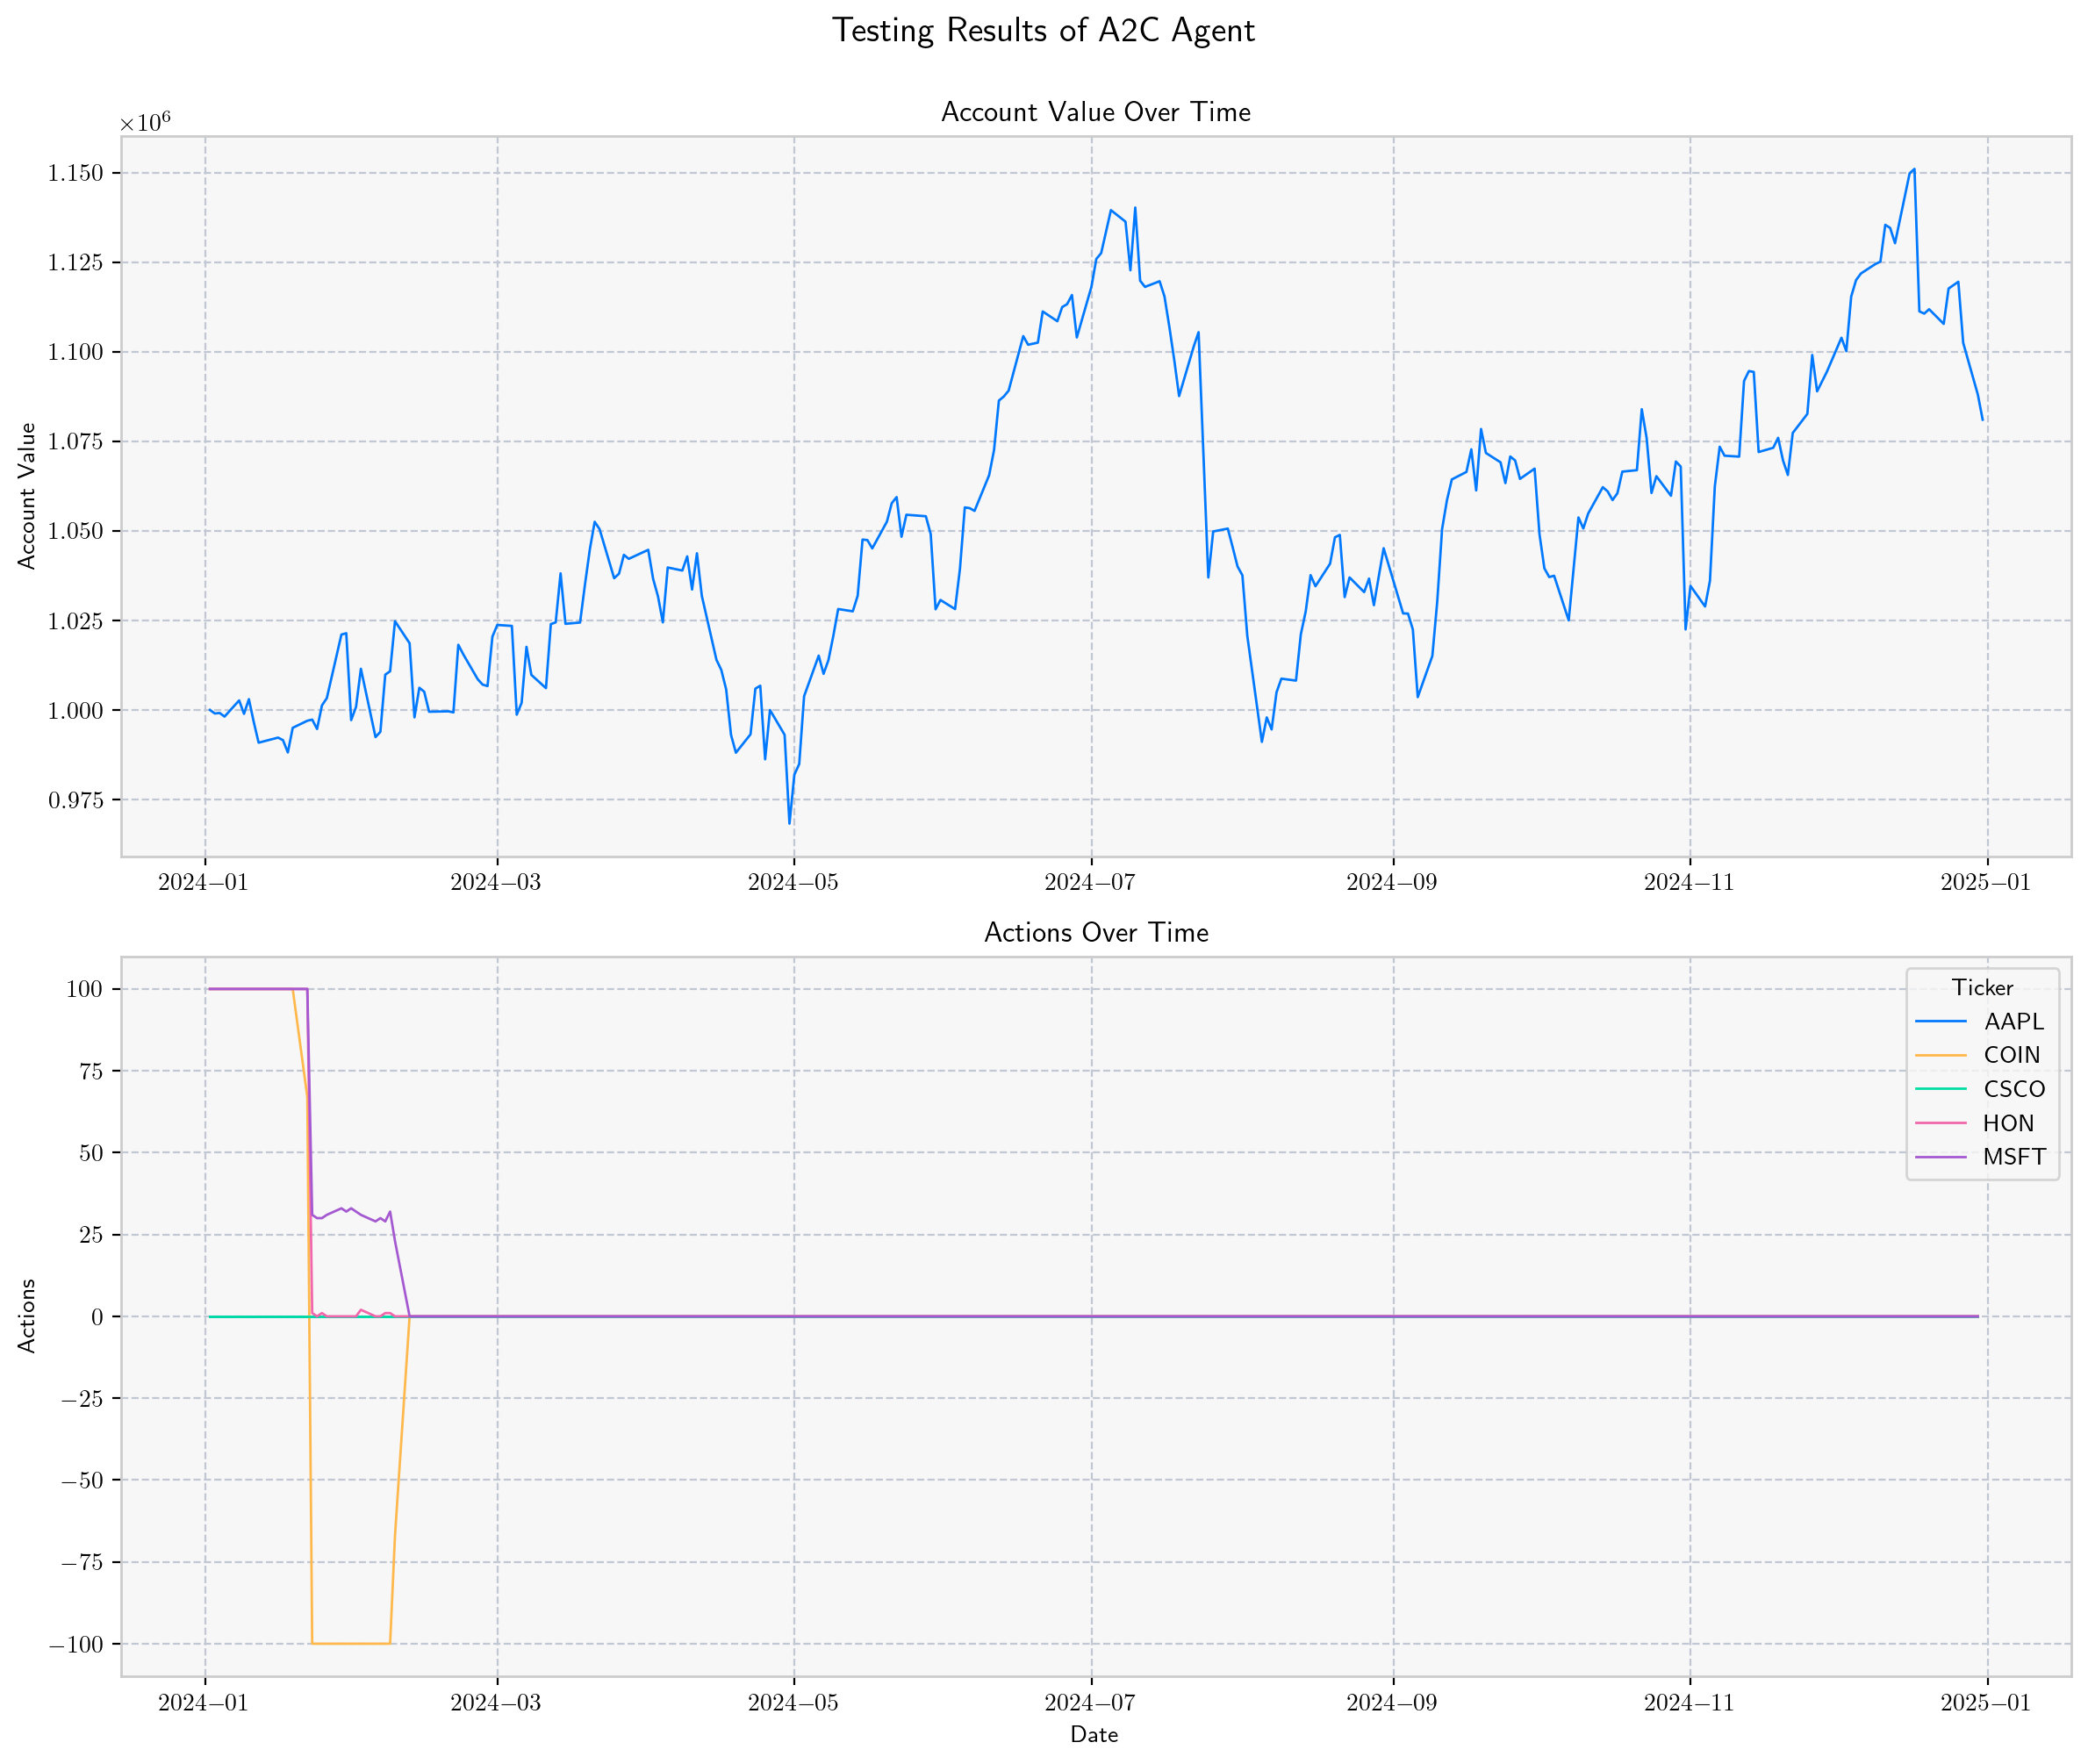

Model arguments: {'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Loading model: PPO
Model successfully loaded from ../models/stock-trading/test_ppo
Evaluating model: PPO


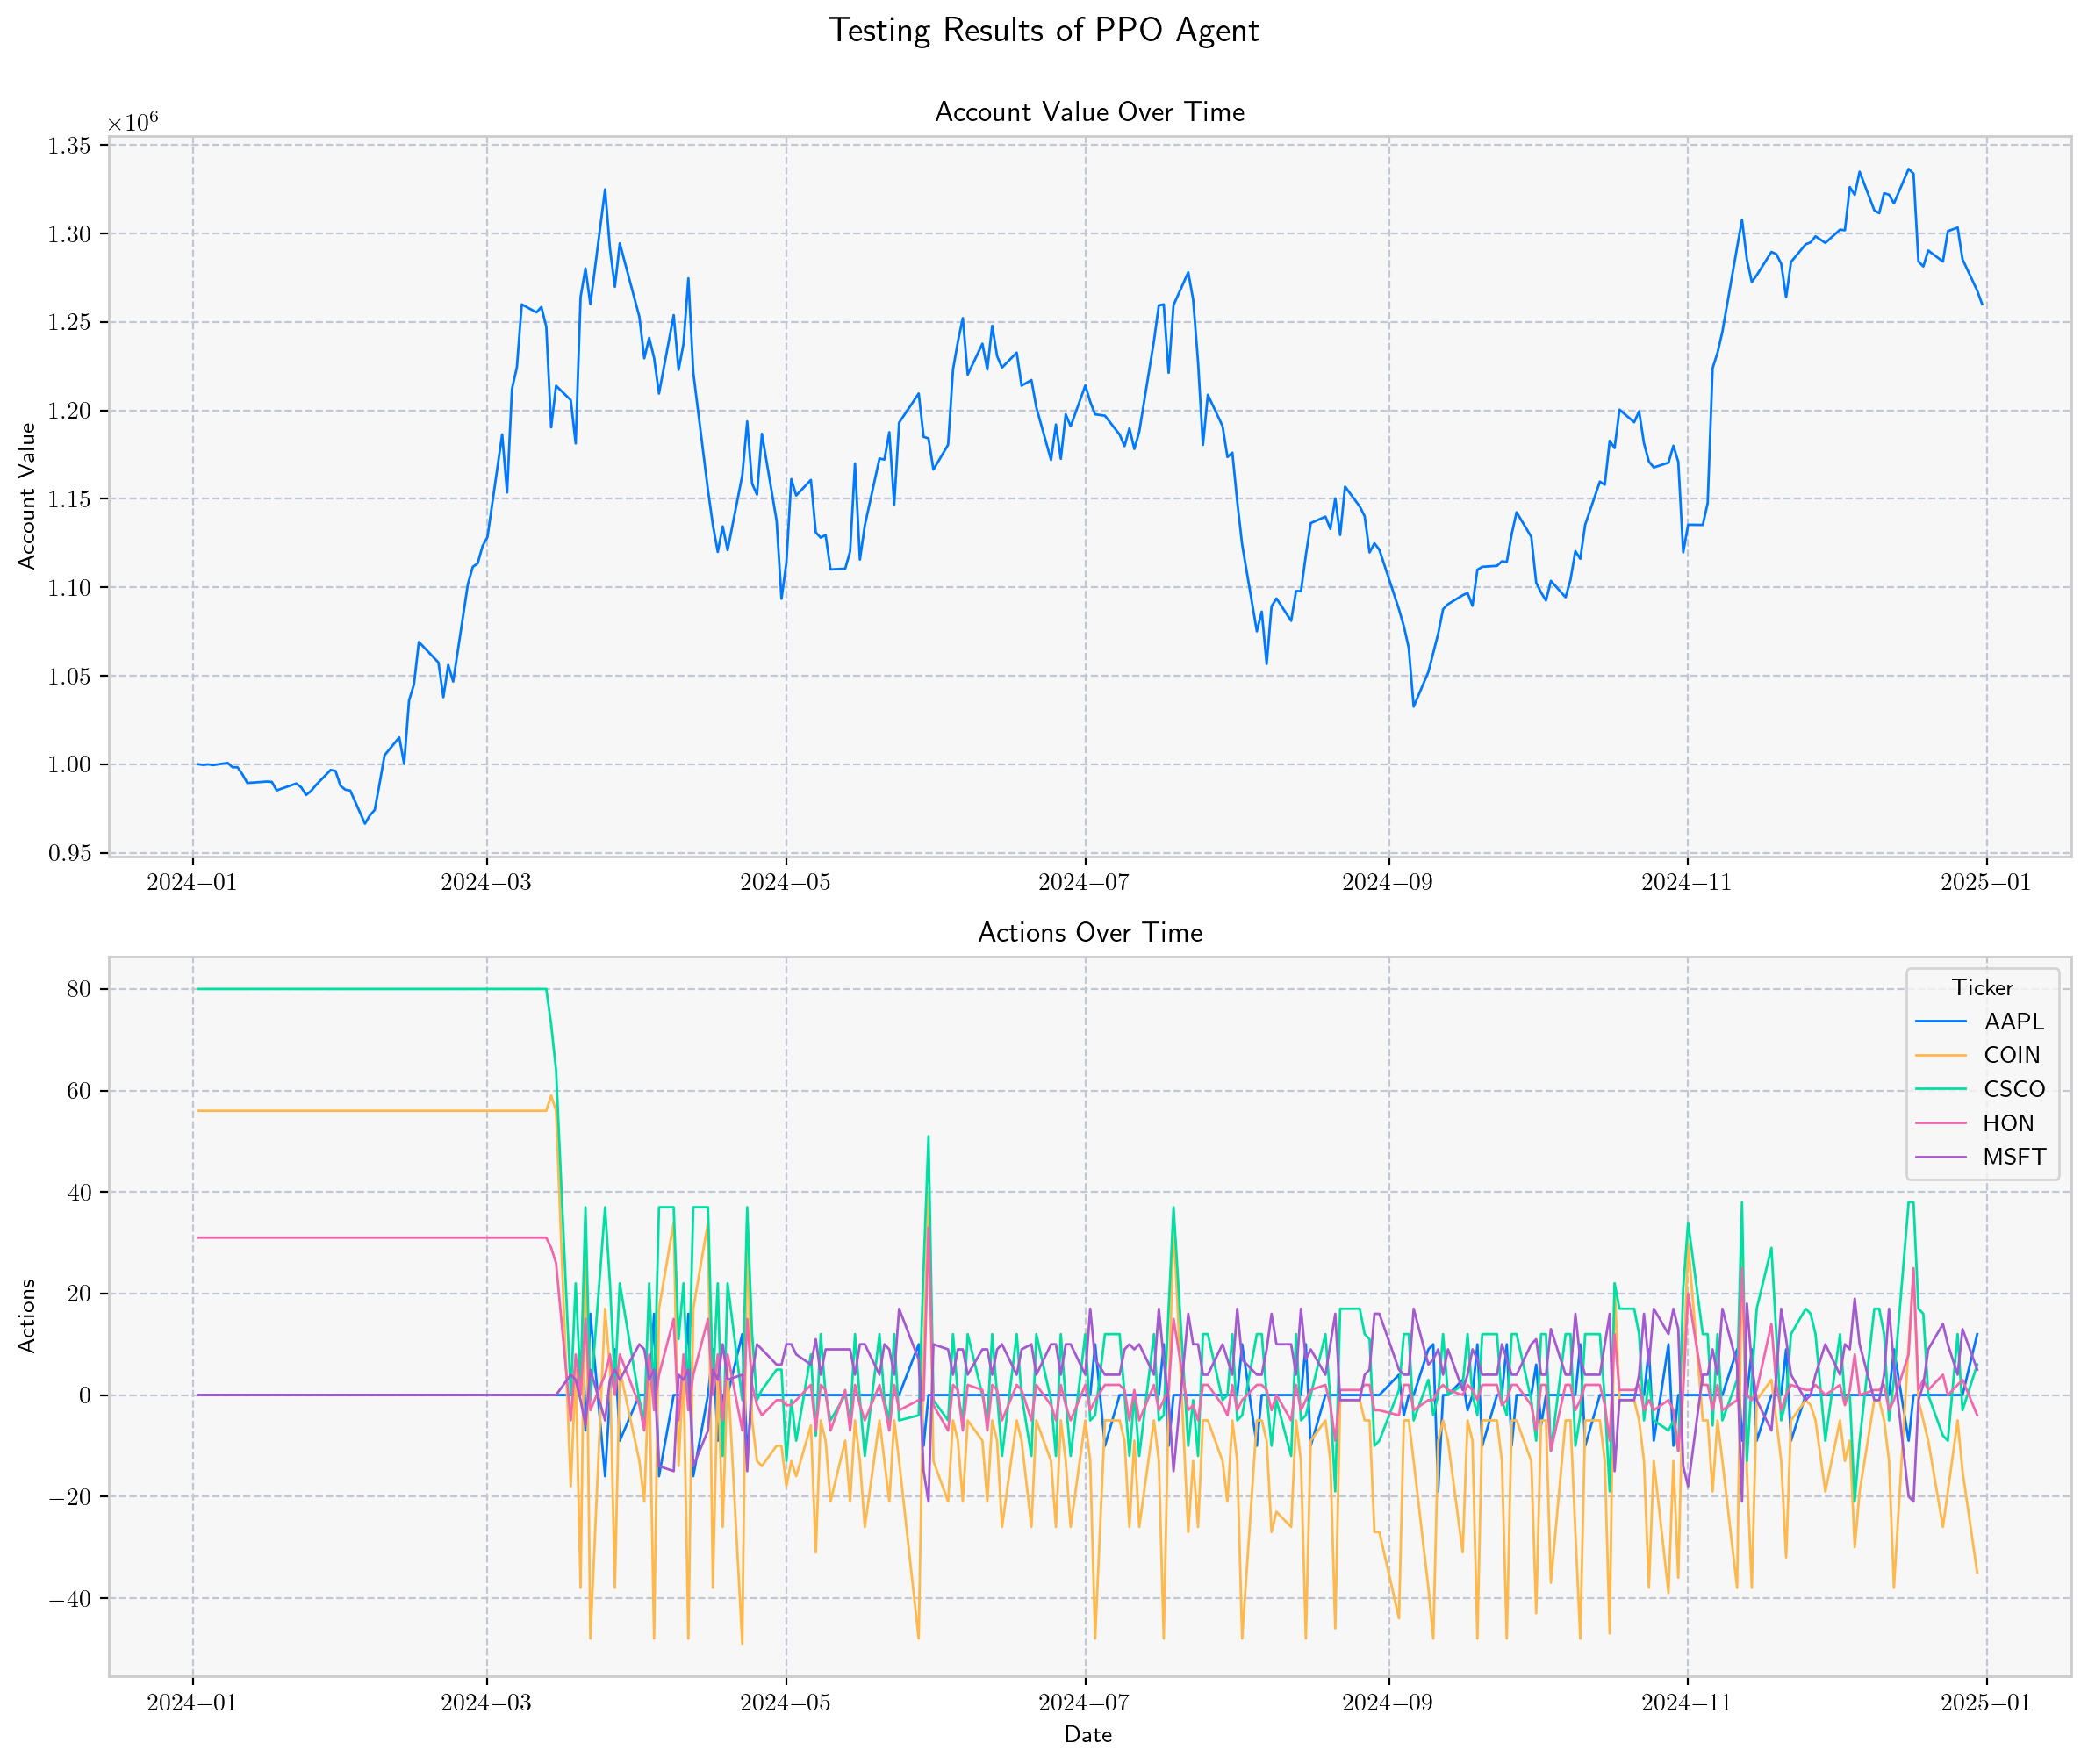

Model arguments: {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Loading model: DDPG
Model successfully loaded from ../models/stock-trading/test_ddpg
Evaluating model: DDPG


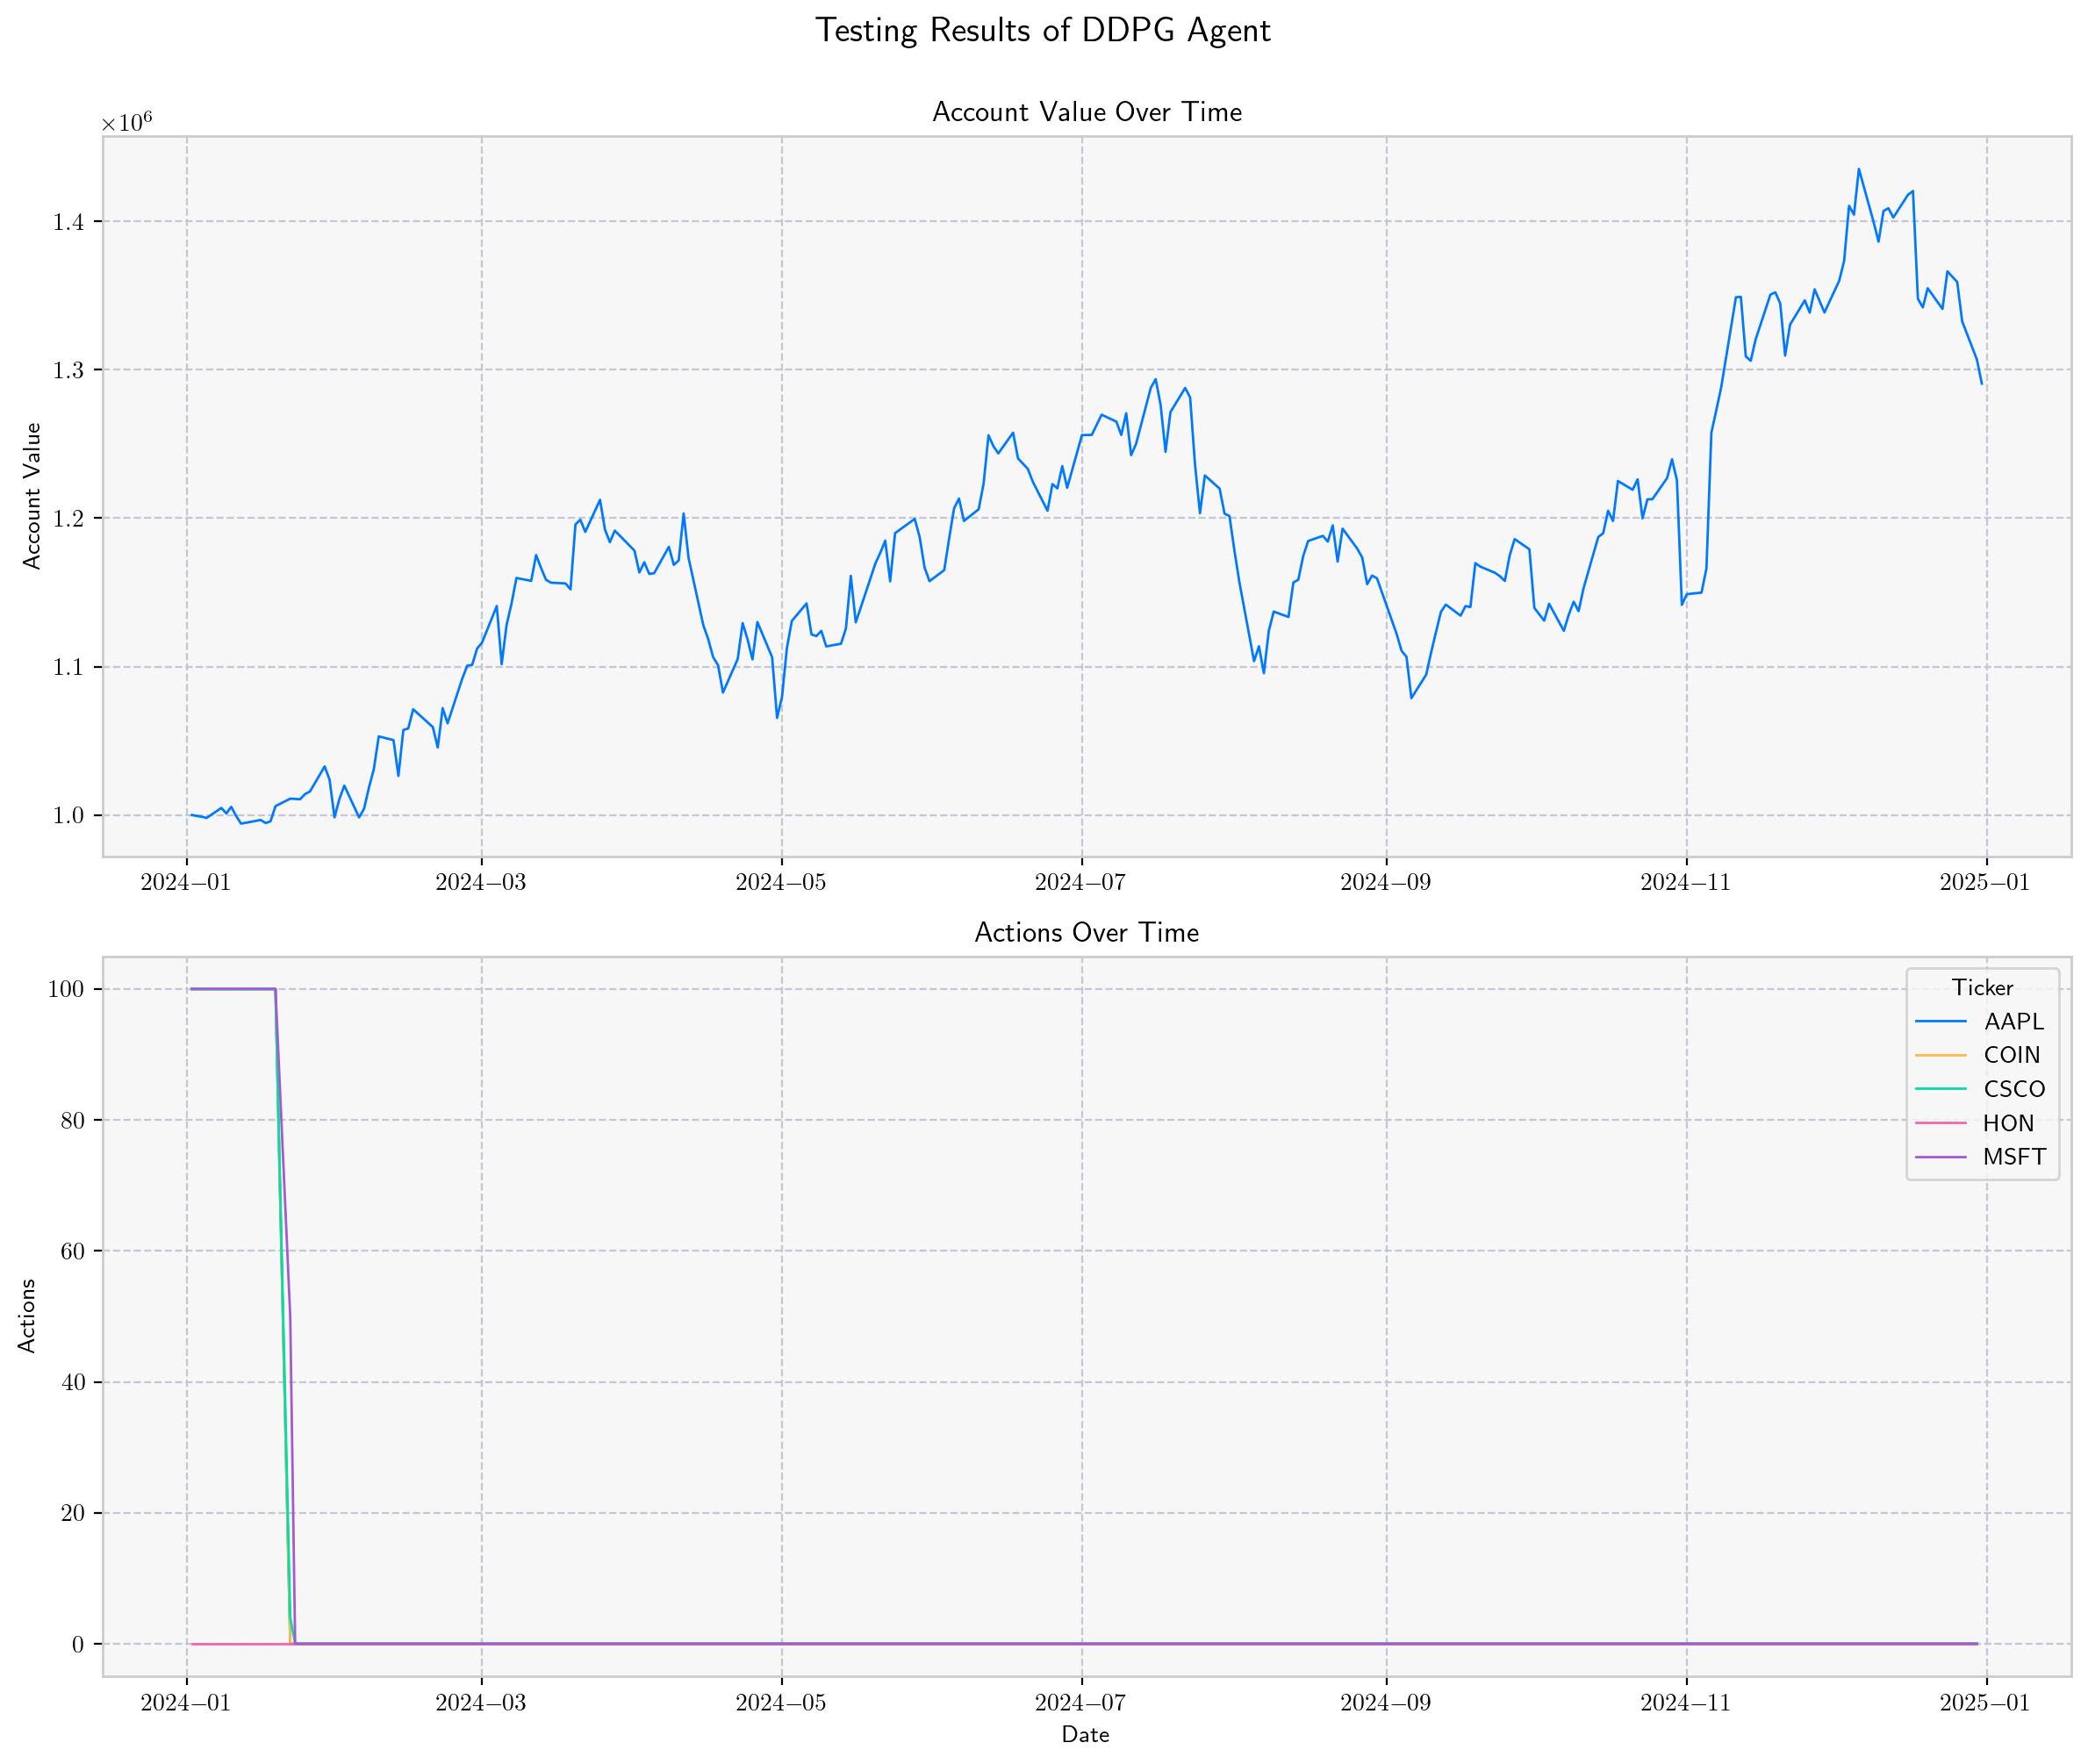

Model arguments: {'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Loading model: TD3
Model successfully loaded from ../models/stock-trading/test_td3
Evaluating model: TD3


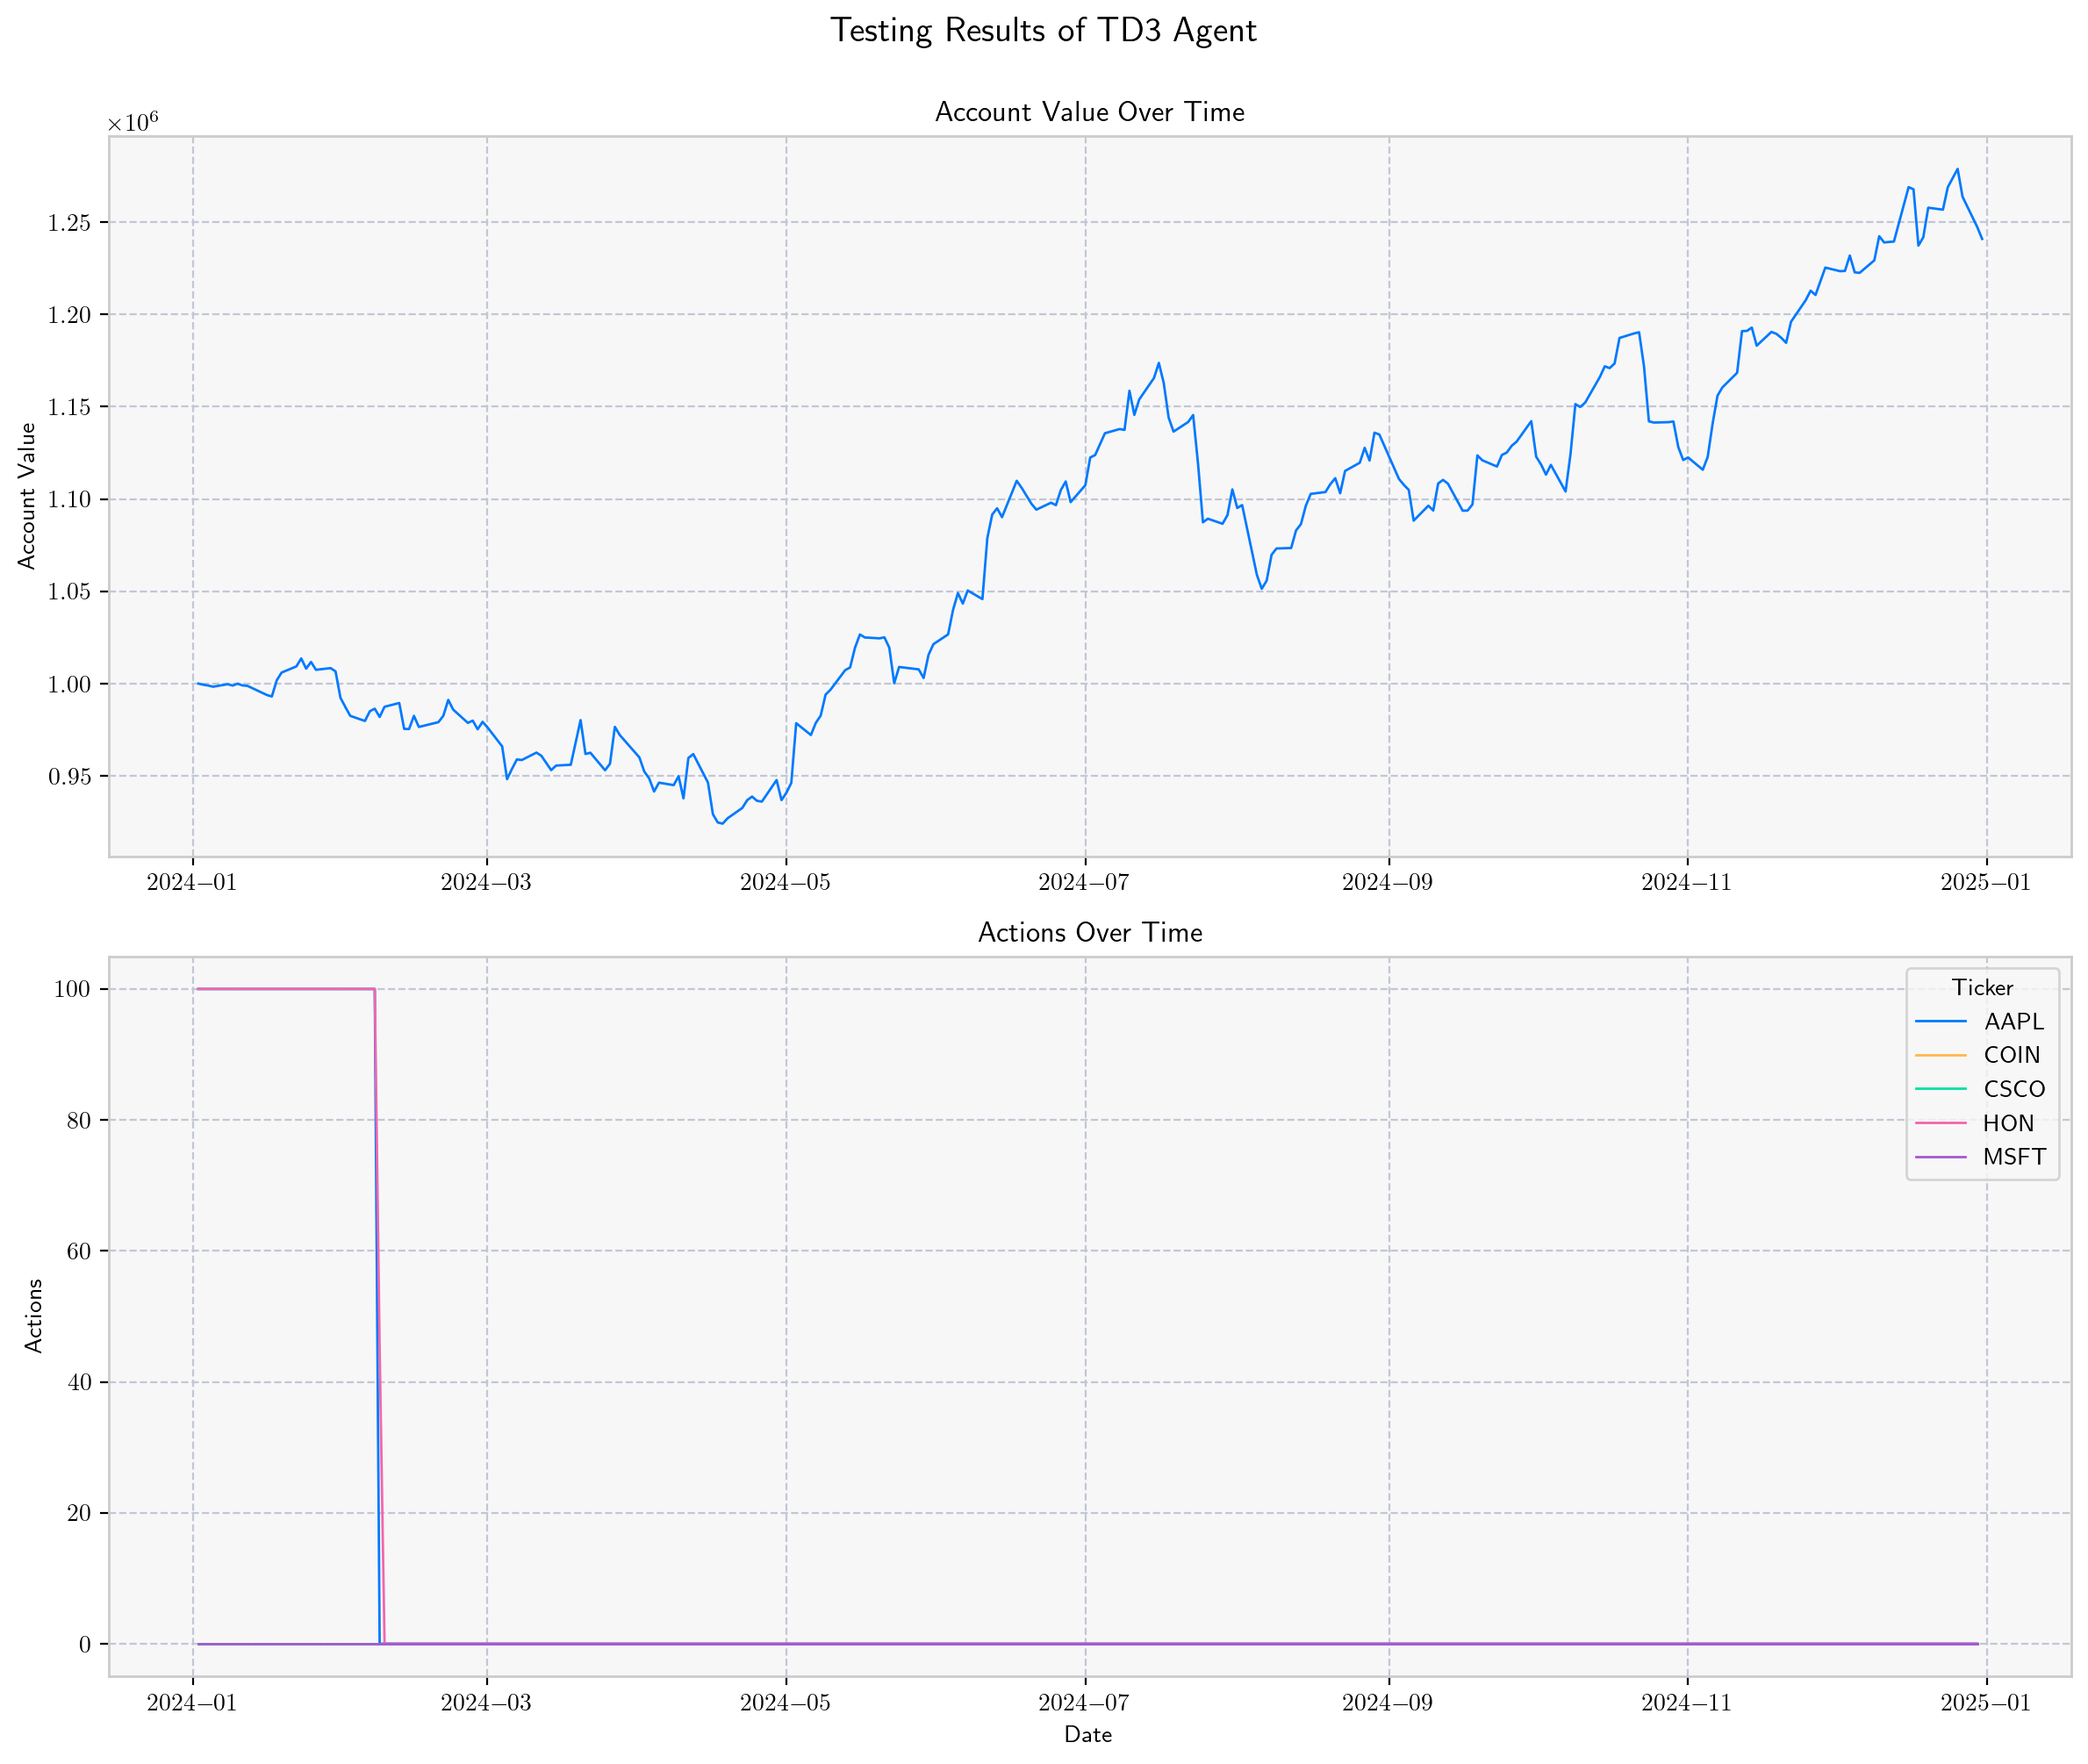

Model arguments: {'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 1000, 'ent_coef': 'auto_0.1'}
Loading model: SAC
Model successfully loaded from ../models/stock-trading/test_sac
Evaluating model: SAC


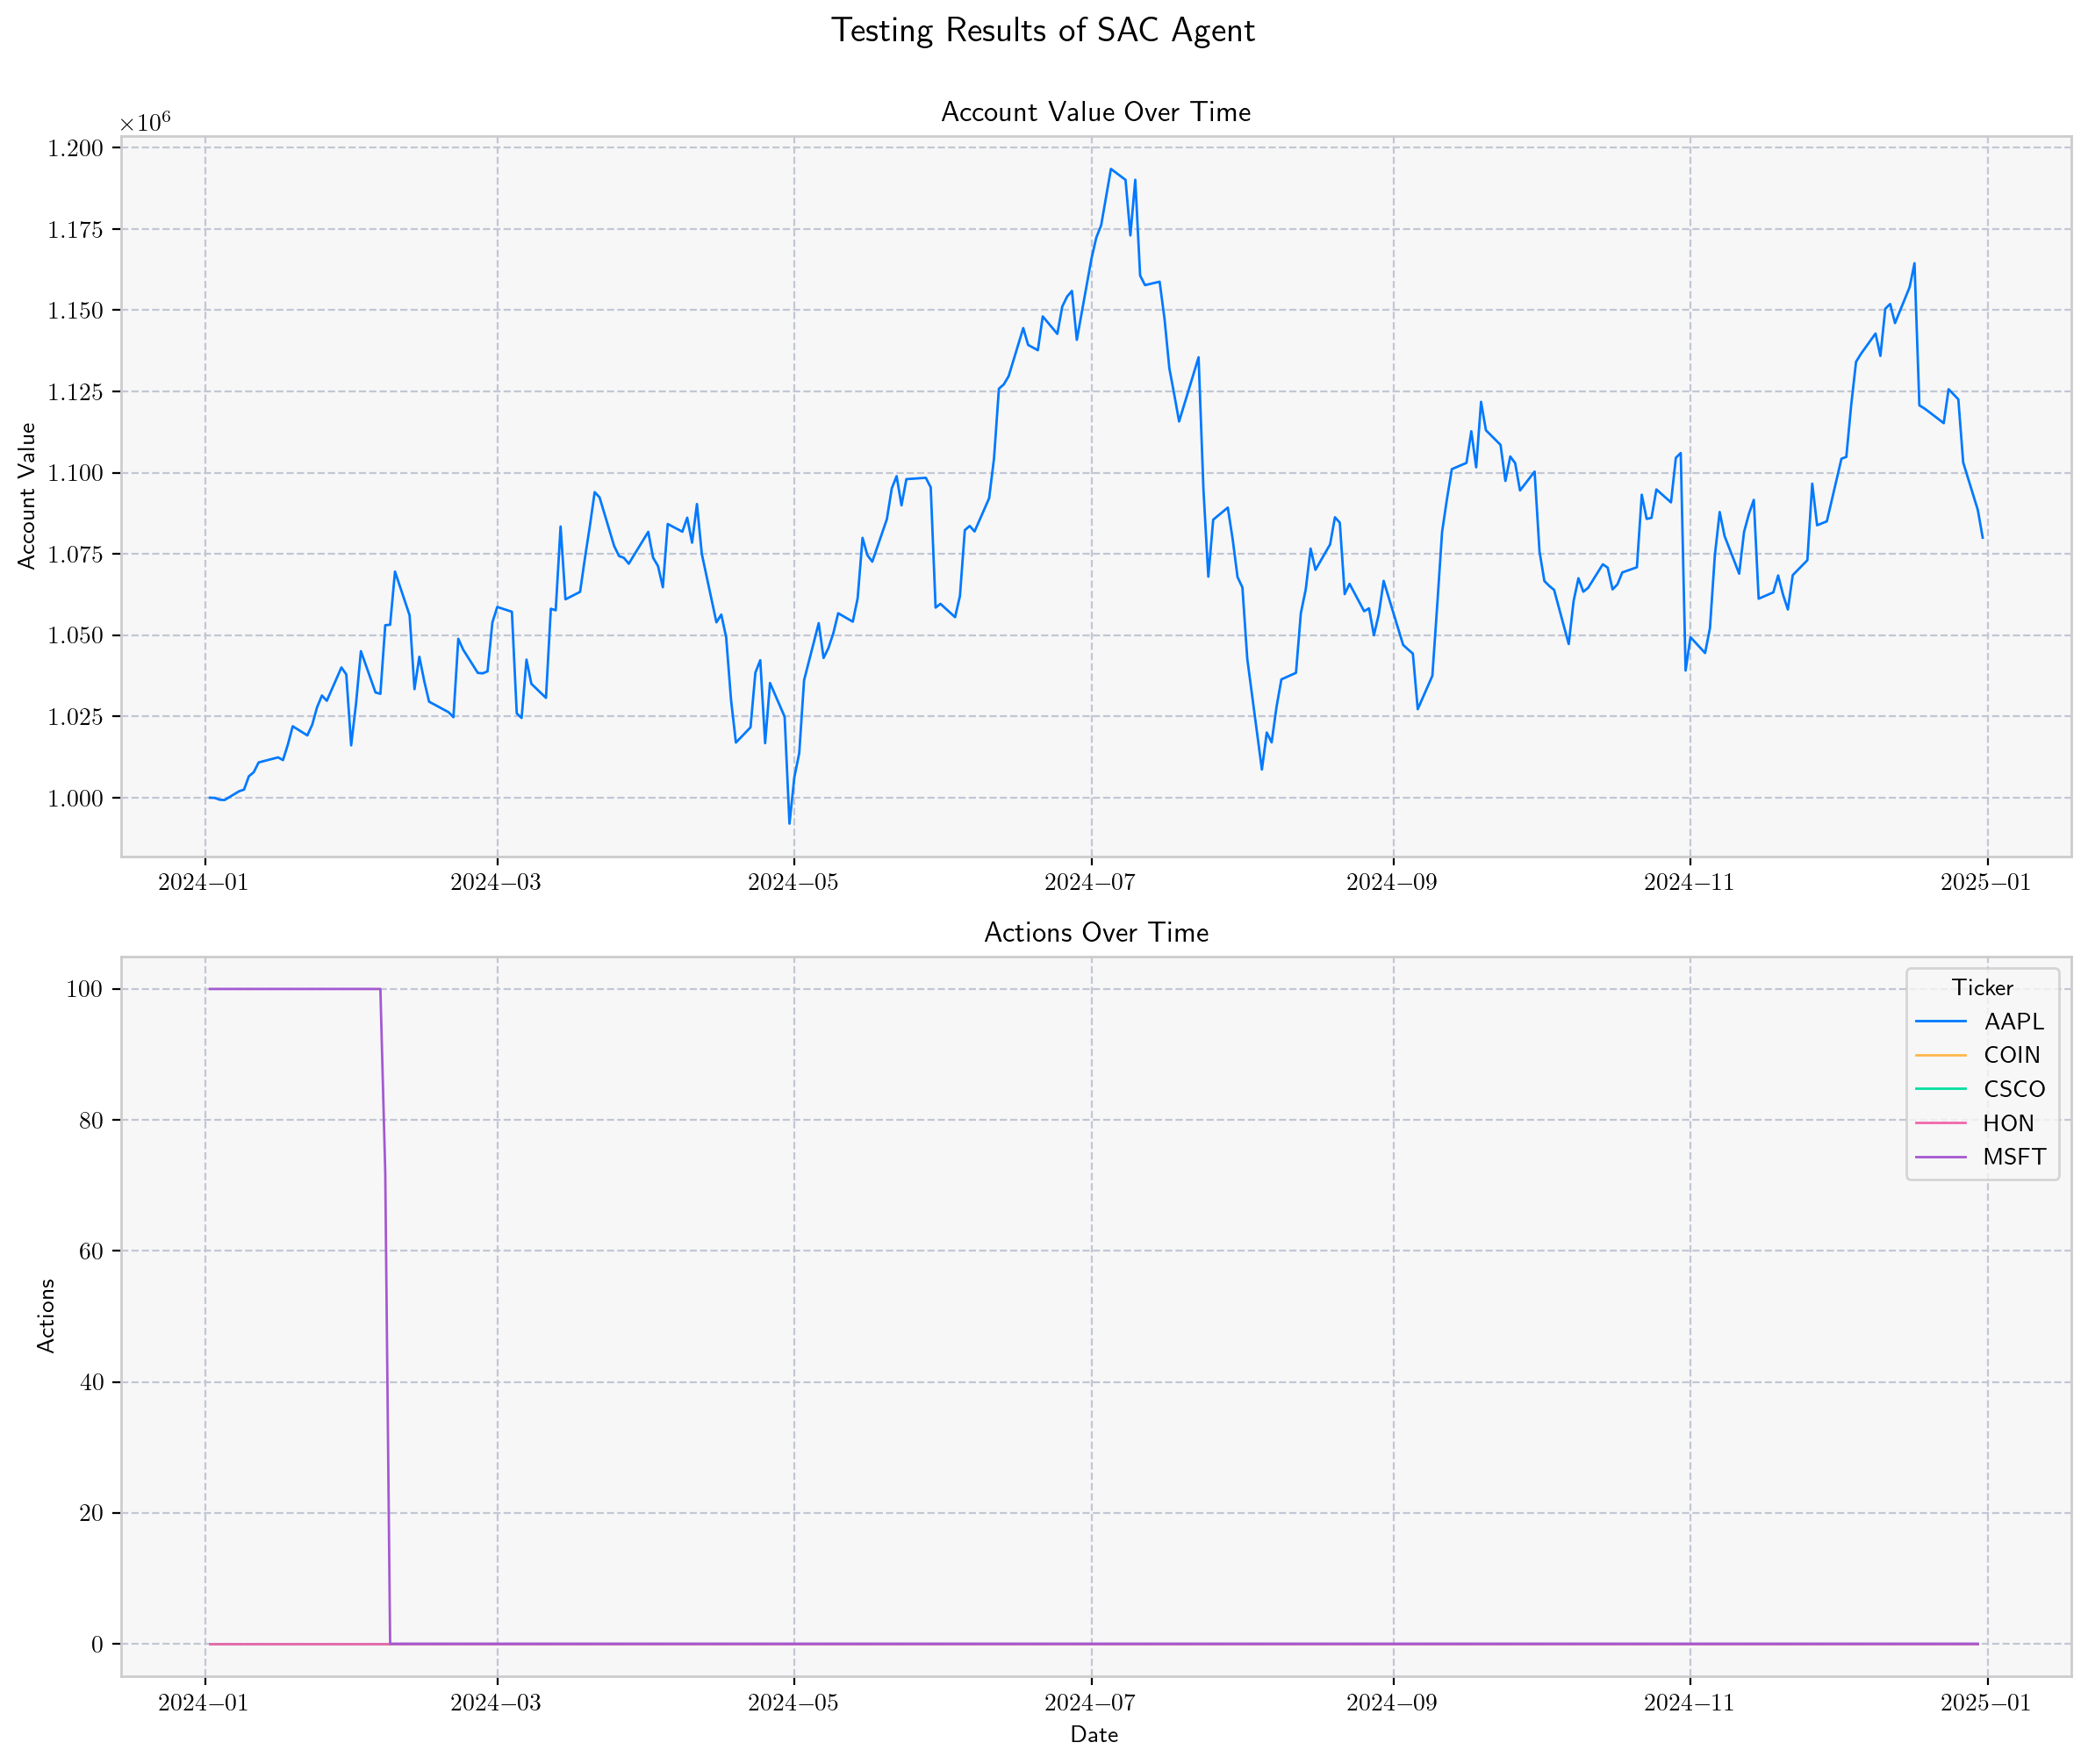

In [ ]:
for model_name in config.MODELS:

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    model = agent.get_model(
        model_name,
        environment=env_train,
        directory=f"../{config.LOGS_DIR}/stock-trading/{config.TEST_NAME}",
        use_case="stock-trading",
    )

    if TRAIN:
        print(f"Training model: {model_name.upper()}")
        trained_model = agent.train(
            model,
            tb_log_name=model_name,
        )
        print(f"Saving model: {model_name.upper()}")
        agent.save_model(
            model,
            model_name,
            f"../{config.MODELS_DIR}/stock-trading",
            config.TEST_NAME,
        )

        visualisation_config = config_models.train_visualisation_config[
            model_name
        ]

        model_visualiser.evaluate_training(
            model_name,
            x=visualisation_config["x"],
            y=visualisation_config["y"],
            title=visualisation_config["title"],
            logs_dir=f"../{config.LOGS_DIR}/stock-trading/{config.TEST_NAME}",
            directory=f"../{config.PLOT_DIR}/stock-trading",
            filename=config.TEST_NAME,
        )

    else:
        print(f"Loading model: {model_name.upper()}")
        trained_model = agent.load_model(
            model_name,
            f"../{config.MODELS_DIR}/stock-trading",
            config.TEST_NAME,
        )

    print(f"Evaluating model: {model_name.upper()}")
    df_account, df_actions = agent.predict(trained_model, gym_env)

    model_visualiser.evaluate_testing(
        model_name,
        df_account,
        df_actions,
        directory=f"../{config.PLOT_DIR}/stock-trading",
        filename=config.TEST_NAME,
    )